In [52]:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import xlrd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [53]:
def open_exl(address, idx):
    data = xlrd.open_workbook(address)
    table = data.sheets()[idx]
    rows = table.nrows
    ct_data = []
    for row in range(rows):
        ct_data.append(table.row_values(row))
    return np.array(ct_data)[:, :4]

def asfloat(data):
    new = np.zeros_like(data, dtype=np.float64)

    for i in range(new.shape[0]):
        for j in range(new.shape[1]):
            new[i, j] = my_float(data[i, j])

    return new

def my_float(x):
    try:
        return float(x)
    except:
        try:
            return float(x[:-1])           
        except:
            return float(x[:-2])

In [54]:
all_data = np.genfromtxt('PUBG_Player_Statistics.csv', delimiter=',')


In [55]:
ps = pd.read_csv(r"C:\Users\sulma\Downloads\Kaggle Datasets\PUBG\PUBG-hack-detection-master\PUBG_Player_Statistics.csv")

In [56]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87898 entries, 0 to 87897
Columns: 152 entries, player_name to squad_DBNOs
dtypes: float64(83), int64(68), object(1)
memory usage: 101.9+ MB


Drop columns that are not in the solo category

In [57]:
ps.iloc[:, 0:52]
solo = ps.copy()
cols= np.arange(52, 152, 1)
solo.drop(solo.columns[cols],axis=1,inplace=True)
# Drop player_name information
solo.drop(solo.columns[[0, 1]],axis=1,inplace=True)
# Drop Knockout column since this is solo
solo.drop(solo.columns[[49]],axis=1,inplace=True)
solo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87898 entries, 0 to 87897
Data columns (total 49 columns):
solo_KillDeathRatio         87898 non-null float64
solo_WinRatio               87898 non-null float64
solo_TimeSurvived           87898 non-null float64
solo_RoundsPlayed           87898 non-null int64
solo_Wins                   87898 non-null int64
solo_WinTop10Ratio          87898 non-null float64
solo_Top10s                 87898 non-null int64
solo_Top10Ratio             87898 non-null float64
solo_Losses                 87898 non-null int64
solo_Rating                 87898 non-null float64
solo_BestRating             87898 non-null float64
solo_DamagePg               87898 non-null float64
solo_HeadshotKillsPg        87898 non-null float64
solo_HealsPg                87898 non-null float64
solo_KillsPg                87898 non-null float64
solo_MoveDistancePg         87898 non-null float64
solo_RevivesPg              87898 non-null int64
solo_RoadKillsPg            87898 

In [58]:
data = solo.copy()
with pd.option_context('display.max_columns', 52):
    print(data.describe(include='all'))



       solo_KillDeathRatio  solo_WinRatio  solo_TimeSurvived  \
count         87898.000000   87898.000000       8.789800e+04   
mean              1.865855       5.017506       6.971571e+04   
std               1.776301      10.077138       8.040861e+04   
min               0.000000       0.000000       7.610000e+01   
25%               1.030000       0.000000       1.789705e+04   
50%               1.470000       2.000000       4.517333e+04   
75%               2.140000       5.560000       9.246264e+04   
max             100.000000     100.000000       1.521200e+06   

       solo_RoundsPlayed     solo_Wins  solo_WinTop10Ratio   solo_Top10s  \
count       87898.000000  87898.000000        87898.000000  87898.000000   
mean           79.275342      2.080093            0.179251     12.106282   
std            96.947859      3.394513            0.217444     14.694722   
min             1.000000      0.000000            0.000000      0.000000   
25%            17.000000      0.000000     

In [59]:

# 30% of players have lower than 30 kills
print(data['solo_Kills'].quantile(0.25))
# 50% of players have lower than 70 kills
print(data['solo_Kills'].quantile(0.50))
# 75% of players have lower than 133 kills
print(data['solo_Kills'].quantile(0.75))
# 99% of players have lower than 611 kills
print(data['solo_Kills'].quantile(0.99))

30.0
70.0
133.0
611.0


In [65]:
bins = [-1,0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 611]
labels = ['0_kills', "1-10_kills", "11-20_kills", "21-30_kills", "31-40_kills", "41-50_kills", "51-60_kills", "61-70_kills", "71-80_kills", "81-90_kills", "91-100_kills", "101-110_kills", "111-120_kills", "121-130_kills" '131 - 611_kills', '612+_kills']
data['solo_Kills_Category'] = pd.cut(data['solo_Kills'], bins, labels)
data['solo_Kills_Category']

0          (40, 50]
1        (110, 120]
2          (10, 20]
3          (50, 60]
4          (40, 50]
5          (60, 70]
6        (130, 611]
7          (30, 40]
8        (130, 611]
9          (20, 30]
10       (130, 611]
11       (130, 611]
12       (130, 611]
13       (130, 611]
14         (70, 80]
15          (0, 10]
16       (130, 611]
17       (130, 611]
18         (60, 70]
19       (100, 110]
20       (130, 611]
21       (100, 110]
22         (30, 40]
23         (40, 50]
24              NaN
25              NaN
26       (130, 611]
27       (110, 120]
28       (100, 110]
29         (40, 50]
            ...    
87868    (130, 611]
87869      (70, 80]
87870       (0, 10]
87871      (20, 30]
87872    (100, 110]
87873      (40, 50]
87874      (30, 40]
87875      (20, 30]
87876      (50, 60]
87877    (130, 611]
87878    (130, 611]
87879       (0, 10]
87880      (20, 30]
87881      (50, 60]
87882      (30, 40]
87883      (10, 20]
87884      (70, 80]
87885      (50, 60]
87886      (80, 90]


In [72]:
bins = [-1,0,30,70,133,611, 5033]
labels = ['0_kills','1-30_kills', '31-70_kills', '71-133_kills', '134 - 611_kills', '612+ kills']
data['solo_Kills_Category'] = pd.cut(data['solo_Kills'], bins, include_lowest=True)
data['solo_Kills_Category']

0           (30.0, 70.0]
1          (70.0, 133.0]
2            (0.0, 30.0]
3           (30.0, 70.0]
4           (30.0, 70.0]
5           (30.0, 70.0]
6         (133.0, 611.0]
7           (30.0, 70.0]
8         (133.0, 611.0]
9            (0.0, 30.0]
10        (133.0, 611.0]
11        (133.0, 611.0]
12        (133.0, 611.0]
13        (133.0, 611.0]
14         (70.0, 133.0]
15           (0.0, 30.0]
16        (133.0, 611.0]
17        (133.0, 611.0]
18          (30.0, 70.0]
19         (70.0, 133.0]
20        (133.0, 611.0]
21         (70.0, 133.0]
22          (30.0, 70.0]
23          (30.0, 70.0]
24       (611.0, 5033.0]
25       (611.0, 5033.0]
26        (133.0, 611.0]
27         (70.0, 133.0]
28         (70.0, 133.0]
29          (30.0, 70.0]
              ...       
87868     (133.0, 611.0]
87869      (70.0, 133.0]
87870        (0.0, 30.0]
87871        (0.0, 30.0]
87872      (70.0, 133.0]
87873       (30.0, 70.0]
87874       (30.0, 70.0]
87875        (0.0, 30.0]
87876       (30.0, 70.0]


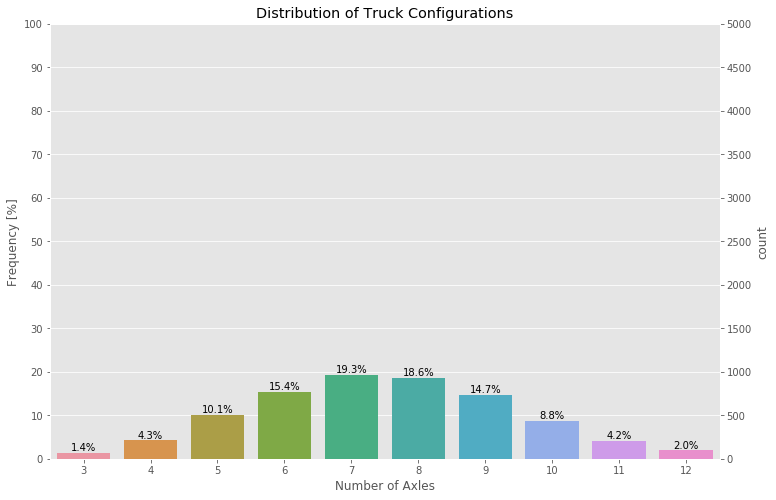

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker

# Some random data
dfWIM = pd.DataFrame({'AXLES': np.random.normal(8, 2, 5000).astype(int)})
ncount = len(dfWIM)
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
ax = sns.countplot(x="AXLES", data=dfWIM, order=[3,4,5,6,7,8,9,10,11,12])
plt.title('Distribution of Truck Configurations')
plt.xlabel('Number of Axles')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

#ax2.grid(color = 'white', axis = 'y')
#ax.set_facecolor("lightgray")
#ax.grid(color ='white', axis = 'y')
#ax.grid(color='white', which='major', axis='x', linestyle='solid')


plt.savefig('snscounter.pdf')

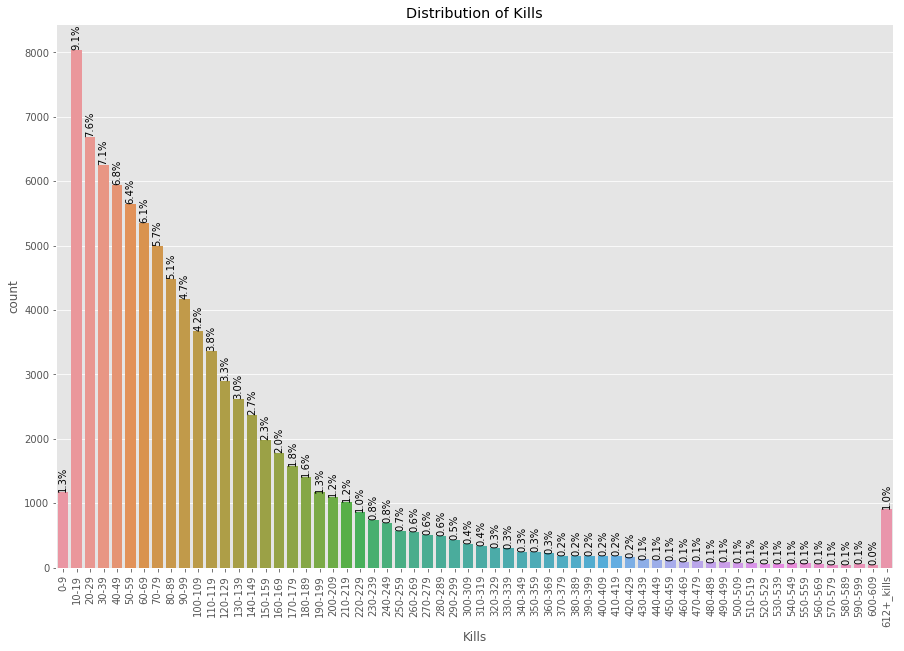

In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker

# Some random data
labels = [str(i)+ '-' + str(i+9) for i in range(0,610,10)] + ['612+_kills']
hello = [-1]+ [i for i in range(0, 610, 10)] + [5033]
data['solo_Kills_Category'] = pd.cut(data['solo_Kills'], hello, labels = labels)
dfWIM = data
ncount = len(dfWIM)
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
ax = sns.countplot(x="solo_Kills_Category", data=dfWIM, order= labels)
plt.title('Distribution of Kills')
plt.xlabel('Kills')
plt.xticks(rotation = 90)


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', rotation = 90) # set the alignment of the text




plt.savefig('snscounter.pdf')

In [138]:
hello = [i for i in range(0, 140, 10)] + [611,5033]
hello


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 611, 5033]

In [140]:
#bins = [-1,0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 611, 5033]
#hello = [i for i in range(0, 600, 10)] + [5033]
hello = [i for i in range(0, 140, 10)] + [611,5033]
hello = hello
labels = ["0-10_kills", "11-20_kills", "21-30_kills", "31-40_kills", "41-50_kills", "51-60_kills", "61-70_kills", "71-80_kills", "81-90_kills", "91-100_kills", "101-110_kills", "111-120_kills", "121-130_kills" ,'131 - 611_kills', '612+_kills']
data['solo_Kills_Category'] = pd.cut(data['solo_Kills'], hello, labels = labels)
data['solo_Kills_Category']


0            41-50_kills
1          111-120_kills
2            11-20_kills
3            51-60_kills
4            41-50_kills
5            61-70_kills
6        131 - 611_kills
7            31-40_kills
8        131 - 611_kills
9            21-30_kills
10       131 - 611_kills
11       131 - 611_kills
12       131 - 611_kills
13       131 - 611_kills
14           71-80_kills
15            0-10_kills
16       131 - 611_kills
17       131 - 611_kills
18           61-70_kills
19         101-110_kills
20       131 - 611_kills
21         101-110_kills
22           31-40_kills
23           41-50_kills
24            612+_kills
25            612+_kills
26       131 - 611_kills
27         111-120_kills
28         101-110_kills
29           41-50_kills
              ...       
87868    131 - 611_kills
87869        71-80_kills
87870         0-10_kills
87871        21-30_kills
87872      101-110_kills
87873        41-50_kills
87874        31-40_kills
87875        21-30_kills
87876        51-60_kills


In [194]:
labels = [str(i)+ '-' + str(i+9) for i in range(0,610,10)] + ['612+_kills']
hello = [-1]+ [i for i in range(0, 610, 10)] + [5033]
print(len(labels))
print(len(hello))
print(labels)
print(hello)

62
63
['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129', '130-139', '140-149', '150-159', '160-169', '170-179', '180-189', '190-199', '200-209', '210-219', '220-229', '230-239', '240-249', '250-259', '260-269', '270-279', '280-289', '290-299', '300-309', '310-319', '320-329', '330-339', '340-349', '350-359', '360-369', '370-379', '380-389', '390-399', '400-409', '410-419', '420-429', '430-439', '440-449', '450-459', '460-469', '470-479', '480-489', '490-499', '500-509', '510-519', '520-529', '530-539', '540-549', '550-559', '560-569', '570-579', '580-589', '590-599', '600-609', '612+_kills']
[-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 5033]


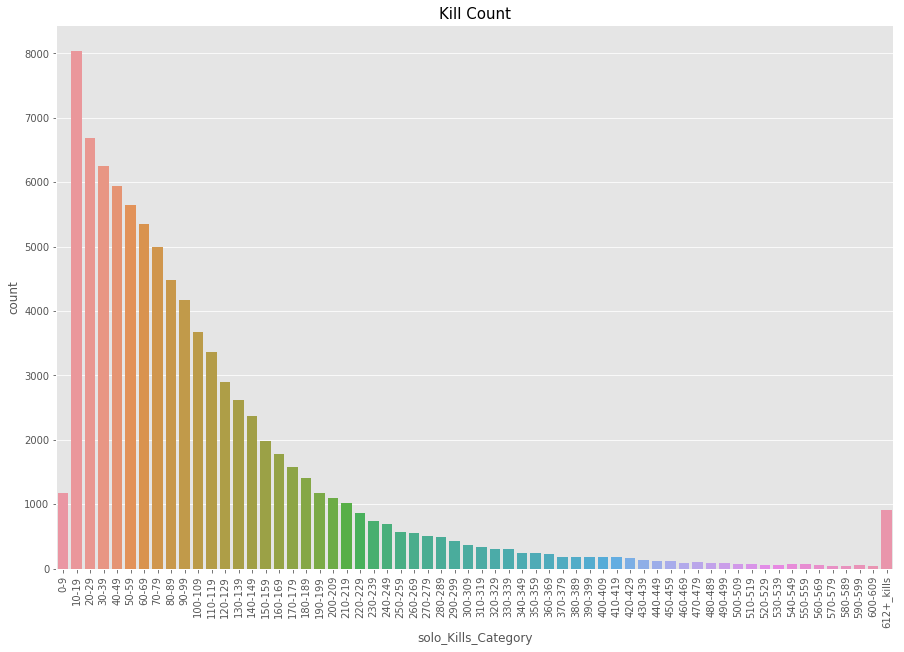

In [197]:
labels = [str(i)+ '-' + str(i+9) for i in range(0,610,10)] + ['612+_kills']
hello = [-1]+ [i for i in range(0, 610, 10)] + [5033]
data['solo_Kills_Category'] = pd.cut(data['solo_Kills'], hello, labels = labels)
plt.style.use('ggplot')

plt.figure(figsize=(15,10))
sns.countplot(data['solo_Kills_Category'])
plt.title("Kill Count",fontsize=15)
plt.xticks(rotation = 90)

plt.show()




In [ ]:
bins = [-1,0,30,70,133,611, 5033]
labels = ['0_kills','1-30_kills', '31-70_kills', '71-133_kills', '134 - 611_kills', '612+_kills']
data['solo_Kills_Category'] = pd.cut(data['solo_Kills'], bins, labels)
plt.figure(figsize=(15,10))
sns.countplot(data['solo_Kills_Category'])
plt.title("Kill Count",fontsize=15)
plt.xticks(rotation = 90)
plt.show()



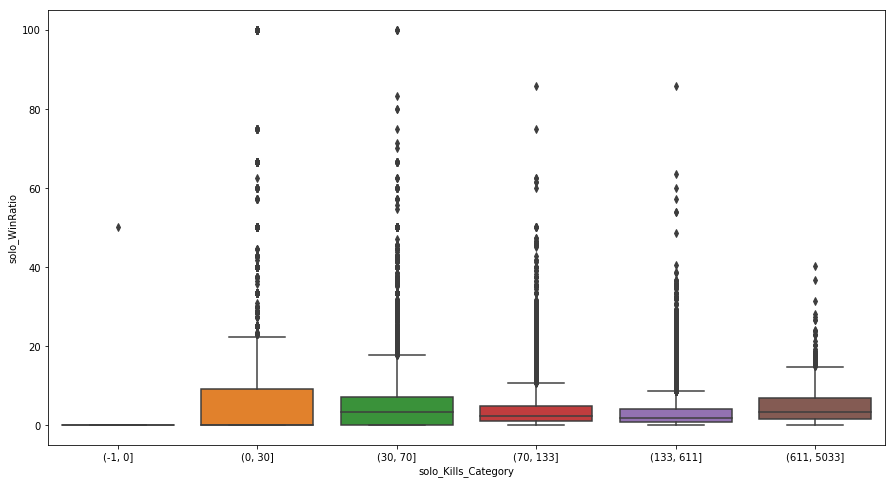

In [19]:
plt.figure(figsize=(15,8))
sns.boxplot(x='solo_Kills_Category', y="solo_WinRatio", data=data)
plt.show()

Firstly, this is not a good represenative of the data as we can identify there are a ton of outliers! Now we'll examine this area in the next section, when we actually cluster. 

In [ ]:
data['solo_TotalDistance'] = data['solo_WalkDistance'] + data['solo_RideDistance']
data['solo_TotalDistancePg'] = data['solo_AvgWalkDistance'] + data['solo_AvgRideDistance']

C:\Users\sulma\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


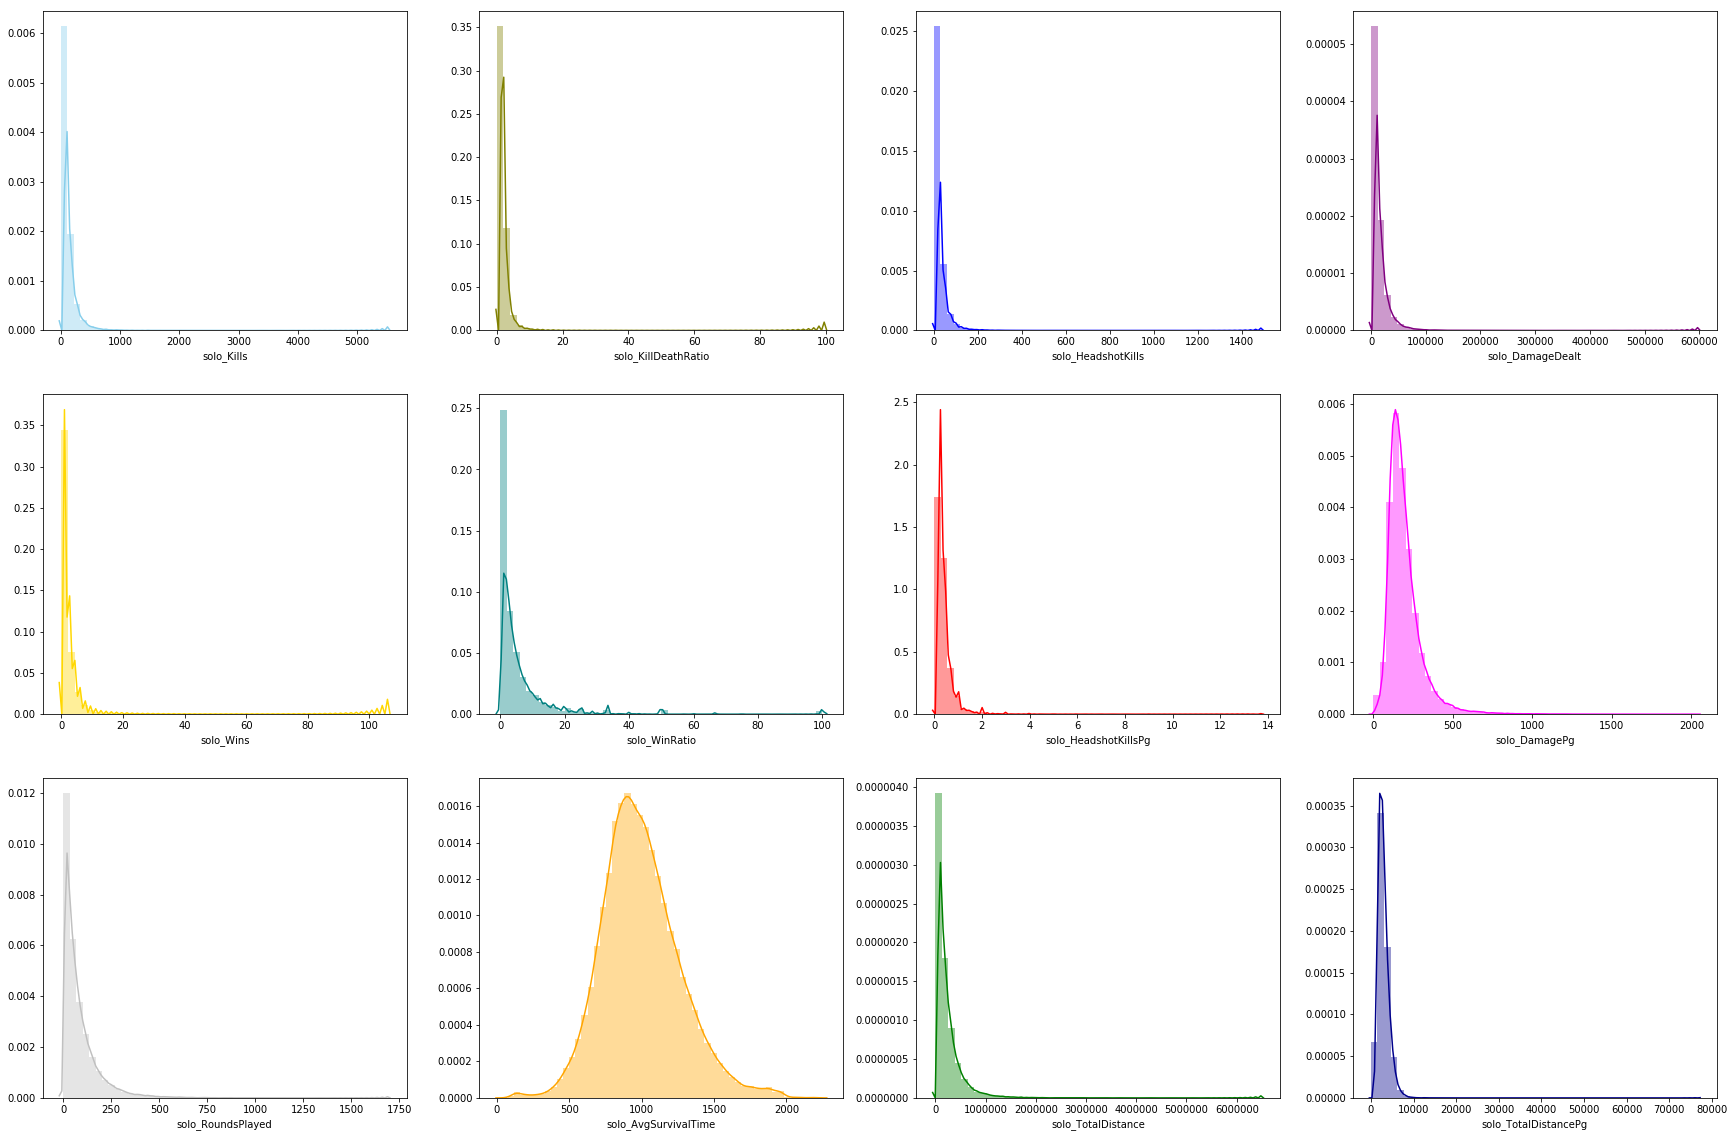

In [49]:
f, axes = plt.subplots(3, 4, figsize=(30,20 ), sharex=False)
sns.distplot( data["solo_Kills"] , color="skyblue", ax=axes[0, 0])
sns.distplot( data["solo_KillDeathRatio"] , color="olive", ax=axes[0, 1])
sns.distplot( data["solo_Wins"] , color="gold", ax=axes[1, 0])
sns.distplot( data["solo_WinRatio"] , color="teal", ax=axes[1, 1])
sns.distplot( data["solo_HeadshotKills"] , color="blue", ax=axes[0, 2])
sns.distplot( data["solo_HeadshotKillsPg"] , color="red", ax=axes[1, 2])
sns.distplot( data["solo_DamageDealt"] , color="purple", ax=axes[0, 3])
sns.distplot( data["solo_DamagePg"] , color="magenta", ax=axes[1, 3])
sns.distplot( data["solo_RoundsPlayed"] , color="silver", ax=axes[2, 0])
sns.distplot( data["solo_AvgSurvivalTime"] , color="orange", ax=axes[2, 1])
sns.distplot( data['solo_TotalDistance'] , color="green", ax=axes[2, 2])
sns.distplot( data["solo_TotalDistancePg"] , color="darkblue", ax=axes[2, 3])


((array([-4.31762704, -4.11760597, -4.00876777, ...,  4.00876777,
          4.11760597,  4.31762704]),
  array([  76.1 ,   79.63,   81.04, ..., 2183.46, 2185.64, 2196.84])),
 (267.51285141906254, 996.532800973856, 0.9922315523440398))

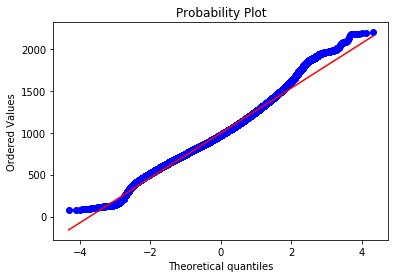

In [59]:
#stats.probplot(data['solo_Kills'], plot=sns.mpl.pyplot)
stats.probplot(data['solo_AvgSurvivalTime'], plot=sns.mpl.pyplot)

Examining this shows that we have a right-tailed distribution, where most of the data falls in the lower bounds.

AvgSurvivalTime is indeed normal, as supported by the Q-Q plot.

In [ ]:
# load data from first 100 ranking in 5 servers
asia = open_exl('pubg_as.xls', 0)
eu = open_exl('pubg_eu.xls', 0)
na = open_exl('pubg_na.xls', 0)
oc = open_exl('pubg_oc.xls', 0)
sea = open_exl('pubg_sea.xls', 0)

# Load all data
all_data = np.genfromtxt('PUBG_Player_Statistics.csv', delimiter=',')
all_data[:, 28] = all_data[:, 28] * 100

# Train data
train_data = all_data[1:2000, :][:, [3, 2, 28, 9]]
test_data = all_data[2000:, :][:, [3, 2, 28, 9]]
all_data

In [ ]:
data = np.vstack((asia[1:], eu[1:], na[1:], oc[1:], sea[1:], train_data[1:]))
df = pd.DataFrame({data[0, i]: data[1:, i] for i in range(data.shape[1])})
m = asfloat(data[1:, :4])

In [ ]:
df.describe()

In [ ]:
#df_copy = df.copy()
#df_copy.columns = ['Win Rate', 'KDR', 'Headshot Kill Ratio', 'Top 10 Ratio']
#df_float = df_copy.copy()
#df_float["Win Rate"] = pd.to_numeric(df_float["Win Rate"],errors='coerce')
#df_float["KDR"] = pd.to_numeric(df_float["KDR"],errors='coerce')
#df_float["Headshot Kill Ratio"] = pd.to_numeric(df_float["Headshot Kill Ratio"],errors='coerce')
#df_float["Top 10 Ratio"] = pd.to_numeric(df_float["Top 10 Ratio"],errors='coerce')
#df_float.describe()

In [ ]:
dataset = pd.DataFrame({'Win Rate': m[:, 0], 'KDR': m[:, 1], "Headshot Kill Ratio": m[:, 2], "Top 10 Ratio": m[:, 3]})
dataset.describe()


In [ ]:
number_cluster = 6
kmeans = KMeans(n_clusters=number_cluster).fit(m)
labels = kmeans.labels_

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = ['#fffc4f', '#41f4eb', '#E44B4E', '#F461E6', '#61F464', '#8D77DD', '#f49e42']
label_list = ['Normal player', 'Waller', 'Experienced Player', 'Both', 'God', 'Aimbot']
c_list = [colors[labels[i]] for i in range(m.shape[0])]
center = kmeans.cluster_centers_

plt.figure(figsize=(12, 9))
ax = plt.subplot(111,projection='3d')

for i in range(number_cluster):
    c = m[labels == i]
    x,y,z = c[:,0],c[:,1],c[:,2]
    x_c, y_c, z_c = center[:, 0], center[:, 1], center[:, 2]
    ax.scatter(x, y, z, s=15, color=colors[i], label=label_list[i])
    ax.scatter(x_c, y_c, z_c, s=80, alpha=0.5, c='black')

ax.legend()
ax.set_title('Data of PUBG with Labels Built by KMeans')
ax.set_zlabel('Headshot Kill Ratio')
ax.set_ylabel('KDR')
ax.set_xlabel('Win Rate')
plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(111,projection='3d')

for i in range(number_cluster):
    c = m[labels == i]
    x,y,z = c[:,0],c[:,1],c[:,3]
    x_c, y_c, z_c = center[:, 0], center[:, 1], center[:, 3]
    ax.scatter(x, y, z, s=15, color=colors[i], label=label_list[i])
    ax.scatter(x_c, y_c, z_c, s=80, alpha=0.5, c='black')

ax.legend()
ax.set_title('Data of PUBG with Labels Built by KMeans')
ax.set_zlabel('Top 10 Ratio')
ax.set_ylabel('KDR')
ax.set_xlabel('Win Ratio')
plt.show()

In [ ]:
predict_labels = kmeans.predict(test_data)

In [ ]:
print(np.bincount(predict_labels))
print(predict_labels.shape)

In [ ]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(111,projection='3d')

for i in range(number_cluster):
    c = test_data[predict_labels == i]
    x,y,z = c[:,0],c[:,1],c[:,2]
    x_c, y_c, z_c = center[:, 0], center[:, 1], center[:, 2]
    ax.scatter(x, y, z, s=15, color=colors[i], label=label_list[i])
    ax.scatter(x_c, y_c, z_c, s=80, alpha=0.5, c='black')

ax.legend()
ax.set_title('Prediction of Hack in PUBG')
ax.set_zlabel('Headshot Kill Ratio')
ax.set_ylabel('KDR')
ax.set_xlabel('Win Rate')
plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(111,projection='3d')

for i in range(number_cluster):
    c = test_data[predict_labels == i]
    x,y,z = c[:,0],c[:,1],c[:,3]
    x_c, y_c, z_c = center[:, 0], center[:, 1], center[:, 3]
    ax.scatter(x, y, z, s=15, color=colors[i], label=label_list[i])
    ax.scatter(x_c, y_c, z_c, s=80, alpha=0.5, c='black')

ax.legend()
ax.set_title('Prediction of Hack in PUBG')
ax.set_zlabel('Top 10 Ratio')
ax.set_ylabel('KDR')
ax.set_xlabel('Win Ratio')
plt.show()